In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Logistic loss
def f(A, b, lambd, x):
    n = A.shape[0]
    return 1/n * np.sum(np.log(1 + np.exp(-b * (A @ x)))) + lambd/2 * np.linalg.norm(x)**2

In [15]:
# Gradient for logistic regression
def grad(A, b, lambd, x):
    n = A.shape[0]

    bAx = b * (A @ x)
    grad = -1/n * A.T @ (b / (1 + np.exp(bAx))) + lambd * x

    return grad

In [16]:
# Hessian for logistic regression
def hess(A, b, lambd, x):
    # Compute diagonal corresponding to Hessian
    n = A.shape[0]
    probs = 1 / (1 + np.exp(b * (A @ x)))
    D = np.diag(probs * (1 - probs))

    # Compute Hessian
    hess = 1/n * A.T @ D @ A + lambd * np.eye(x.shape[0])

    return hess

In [17]:
# Compute smoothness upper bound of logistic regression
def get_smoothness_ub(A, lambd):
    n = A.shape[0]
    return np.linalg.norm(A, ord='fro') ** 2 / (4 * n) + lambd

In [18]:
# Armijo line search
def armijo(f_o, x, dx, g, a=0.01, b=0.5):
    t = 1
    while f_o(x + t * dx) > f_o(x) + a * t * np.dot(g, dx):
        t *= b
    return t

In [19]:
# Gradient descent
def gd(A, b, lambd, f_o, grad_o, x0, step_size, max_iter):
    f_reduced = lambda x: f_o(A, b, lambd, x)

    x = x0.copy()
    f_list = [f_reduced(x)]

    for i in range(max_iter):
        x -= step_size * grad_o(A, b, lambd, x)
        f_list.append(f_reduced(x))
        
    return x, np.array(f_list)

In [20]:
# Gradient descent
def gd_armijo(A, b, lambd, f_o, grad_o, x0, max_iter):
    f_reduced = lambda x: f_o(A, b, lambd, x)

    x = x0.copy()
    f_list = [f_reduced(x)]

    for i in range(max_iter):
        g = grad_o(A, b, lambd, x)
        t = armijo(f_reduced, x, -g, g)
        x -= t * g
        f_list.append(f_reduced(x))

    return x, np.array(f_list)

In [21]:
# Newton's method
def newton(A, b, lambd, f_o, grad_o, hess_o, x0, max_iter):
    f_reduced = lambda x: f_o(A, b, lambd, x)

    x = x0.copy()
    f_list = [f_reduced(x)]

    for i in range(max_iter):
        g = grad_o(A, b, lambd, x)
        H = hess_o(A, b, lambd, x)
        dx = np.linalg.solve(H, -g) # Ideally, do Cholesky factorization and solve linear system
        t = armijo(f_reduced, x, dx, g)
        x += t * dx
        f_list.append(f_reduced(x))

    # print(f"Optimal value = {f_list[-1]}")
    return x, np.array(f_list)

In [22]:
def generate_plots(A, b, f_star, f, grad, hess, lambd, x0, max_iter_gd, max_iter_newton):
    # Compute spectrum of Hessian
    H = hess(A, b, lambd, np.zeros(A.shape[1]))
    eigs = np.real(np.linalg.eigvals(H))
    eigs = np.sort(eigs)[::-1]

    print('Condition number = ', eigs[0] / eigs[-1])

    plt.figure()
    plt.semilogy(eigs)
    plt.xlabel('Eigenvalue index')
    plt.ylabel('Eigenvalue')
    plt.title('Hessian spectrum')
    plt.savefig('hessian_spectrum.pdf')
    plt.show()

    # Gradient descent
    smoothness_ub = get_smoothness_ub(A, lambd)
    _, f_gd = gd(A, b, lambd, f, grad, x0, 1/smoothness_ub, max_iter_gd)

    # plt.figure()
    # plt.semilogy(f_gd - f_star)
    
    # plt.xlabel('Iteration')
    # plt.ylabel('Suboptimality')
    # plt.title('Convergence of gradient descent')
    # plt.show()
    # plt.savefig('gd_convergence.pdf')

    # Gradient descent w/ Armijo line search
    _, f_gd_armijo = gd_armijo(A, b, lambd, f, grad, x0, max_iter_gd)

    # plt.figure()
    # plt.semilogy(f_gd_armijo - f_star)

    # plt.xlabel('Iteration')
    # plt.ylabel('Suboptimality')
    # plt.title('Convergence of gradient descent w/ Armijo line search')
    # plt.show()
    # plt.savefig('gd_armijo_convergence.pdf')

    # Newton's method w/ Armijo line search
    _, f_newton = newton(A, b, lambd, f, grad, hess, x0, max_iter_newton)

    # plt.figure()
    # plt.semilogy(f_newton - f_star)

    # plt.xlabel('Iteration')
    # plt.ylabel('Suboptimality')
    # plt.title('Convergence of Newton\'s method w/ Armijo line search')
    # plt.show()
    # plt.savefig('newton_convergence.pdf')

    # Plot all methods together
    plt.figure()
    plt.semilogy(f_gd - f_star, label='GD')
    plt.semilogy(f_gd_armijo - f_star, label='GD w/ Armijo')
    plt.semilogy(f_newton - f_star, label='Newton w/ Armijo')
    plt.xlabel('Iteration')
    plt.ylabel('Suboptimality')
    plt.legend()
    plt.title('Convergence of all methods')
    plt.savefig('all_convergence.pdf')
    plt.show()

In [23]:
A = np.load('./data/data.npy')
b = np.load('./data/labels.npy')
lambd = 10 ** (-2) / A.shape[0]
x0 = np.zeros(A.shape[1])

f_star = 0.009658705699090442  # For A, b

max_iter_gd = 1000
max_iter_newton = 100

Condition number =  308384.79775700625


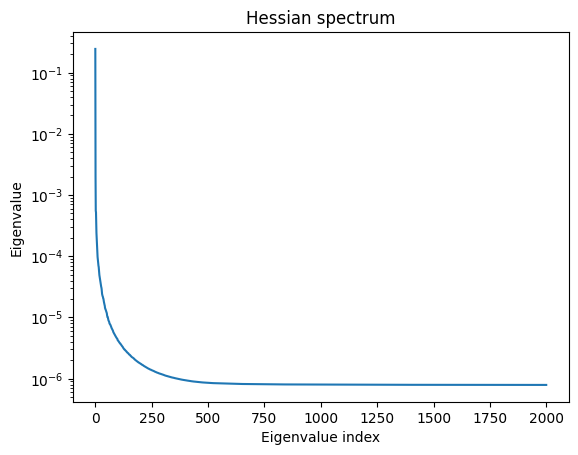

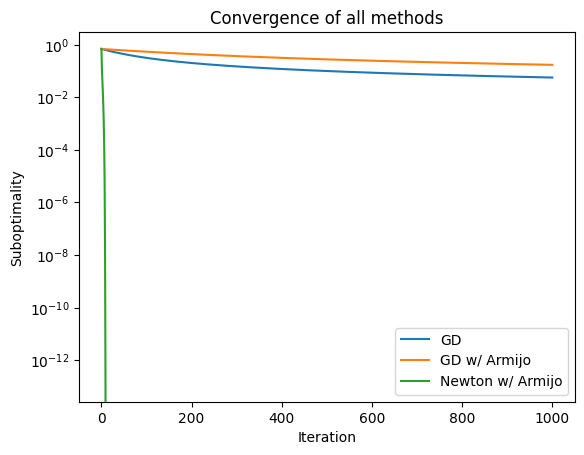

In [24]:
generate_plots(A, b, f_star, f, grad, hess, lambd, x0, max_iter_gd, max_iter_newton)